In [70]:
import json

import numpy as np
import pandas as pd
import torch
from retnext.transforms import BoltzmannFactor, RandomRotate90, RandomReflect, RandomFlip
from moxel.utils import voxels_from_file
import matplotlib.pyplot as plt
from ase.io import read
import seaborn as sns

## Visualize voxelization schemes

In [17]:
tfm = BoltzmannFactor()
cubic_box = None  # Set it to float for the new scheme.

irmof_1 = tfm(
    torch.tensor(voxels_from_file('/home/asarikas/temp/CIFs/IRMOF-1.cif', 32, cubic_box=cubic_box))
).numpy()

irmof_16 = tfm(
    torch.tensor(voxels_from_file('/home/asarikas/temp/CIFs/IRMOF-16.cif', 32, cubic_box=cubic_box))
).numpy()

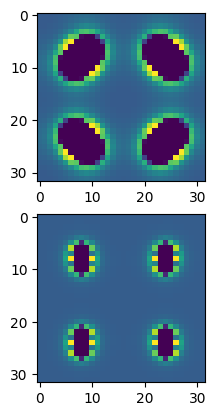

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.imshow(irmof_1[0], cmap='viridis')
ax2.imshow(irmof_16[0], cmap='viridis')

## Visualize augmentations

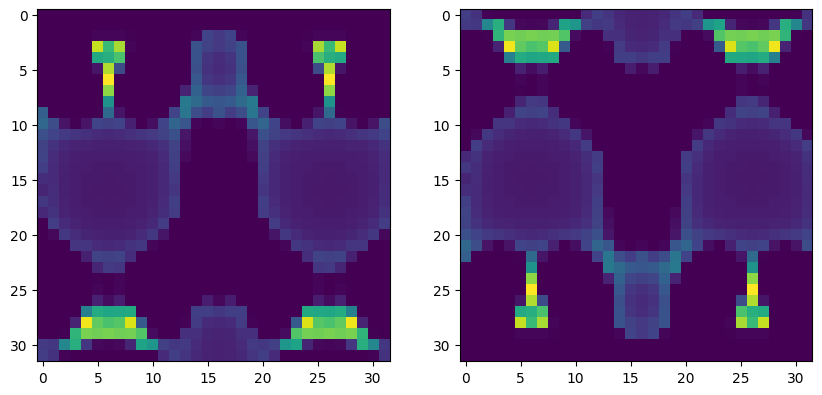

In [26]:
norm = BoltzmannFactor()

#voxels = voxels_from_file('/home/asarikas/temp/CIFs/HKUST-1.cif', 32, cubic_box=30)

orig = norm(torch.tensor(voxels))

aug = RandomFlip()
new = aug(orig.clone().unsqueeze(0))[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 8])

ax1.imshow(orig[0])
ax2.imshow(new[0])

### Sanity check for calculations

In [16]:
path_to_cif = '/home/asarikas/databases/MOFXDB/hMOF/clean_CIFs/hMOF-1.cif'

path_to_npy = '/home/asarikas/databases/MOFXDB/hMOF/voxels_data_GS32/hMOF-1.npy'
non_cubic = np.load(path_to_npy)
print(
    np.array_equal(non_cubic, voxels_from_file(path_to_cif, 32))
)

path_to_npy = '/home/asarikas/databases/MOFXDB/hMOF/voxels_data_GS32_CB30/hMOF-1.npy'
cubic = np.load(path_to_npy)
print(
    np.array_equal(cubic, voxels_from_file(path_to_cif, 32, cubic_box=30))
)

print(np.array_equal(cubic, non_cubic))

True
True
False


## Visualize unit cell statistics

In [4]:
databases = ['hMOF', 'UO', 'Mercado', 'Tobacco', 'CoRE2019']

### Histograms of unit cell statistics

In [8]:
param = 'length'
labels = ['a', 'b', 'c'] if param == 'length' else ['α', 'β', 'γ']

hMOF 15.525756524985564
UO 17.480846590736665
Mercado 45.72927701985489
Tobacco 40.45022889250733
CoRE2019 17.654602216860784
hMOF 88.95378409511696
UO 93.06732125489535
Mercado 93.36996881109202
Tobacco 91.37555398810845
CoRE2019 91.6526673544093


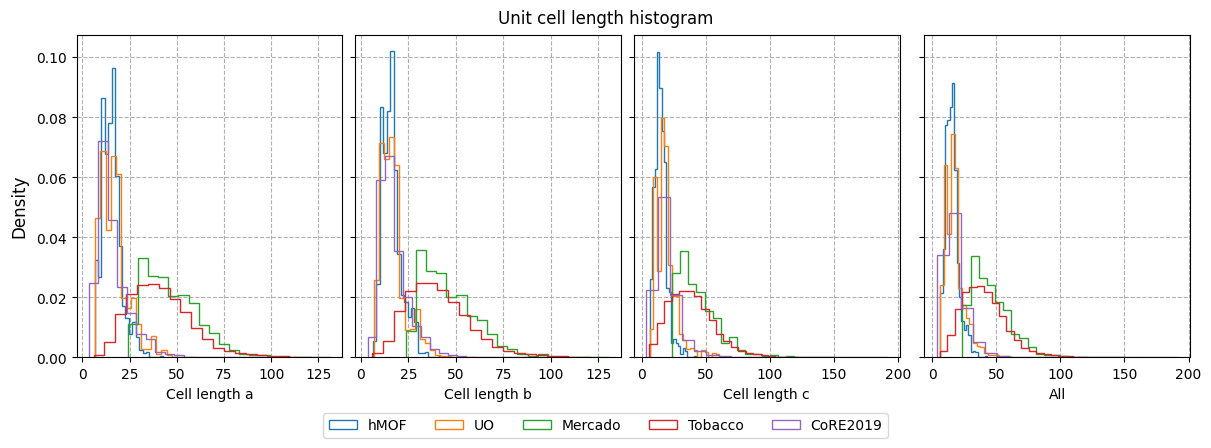

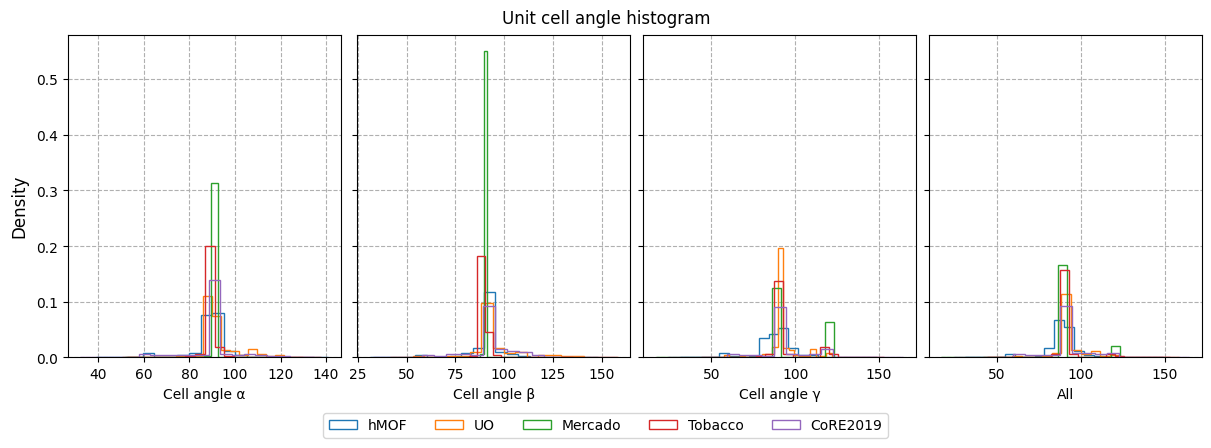

In [10]:
for param in ['length', 'angle']:
    labels = ['a', 'b', 'c'] if param == 'length' else ['α', 'β', 'γ']
    
    fig, axes = plt.subplots(1, 4, figsize=[12, 4], layout='constrained', sharey=True)

    for db in databases:
        with open(f'stats/{db}_unit_cell_stats.json') as fhand:
            data = json.load(fhand)
            
        values = np.array(data[f'cell_{param}s'])
        print(db, values.mean())
        
        for i, (ax, lbl) in enumerate(zip(axes, labels)):
            ax.set_axisbelow(True)
            ax.grid(ls='--')
            ax.hist(
                values[:, i],
                bins=20,
                #color=f'C{i}',
                #edgecolor='k',
                linewidth=1,
                density=True,
                histtype='step',
            )
            ax.set_xlabel(f'Cell {param} {lbl}')
        
        axes[3].set_axisbelow(True)
        axes[3].grid(ls='--')
        axes[3].hist(
            values.ravel(),
            bins=20,
            #edgecolor='k',
            #color=f'C{i+1}',
            linewidth=1,
            density=True,
            histtype='step',
            label=db
        )
        axes[3].set_xlabel('All')
        
    fig.supylabel('Density')
    fig.suptitle(f'Unit cell {param} histogram')
    fig.legend(ncols=5, loc='lower center', bbox_to_anchor=(0.5, -0.1))
    #fig.legend(ncols=4, loc='upper right')
    #plt.savefig(f'figures/{param}_histogram.pdf', bbox_inches='tight')

### Cumulative distribution function of unit cell statistics

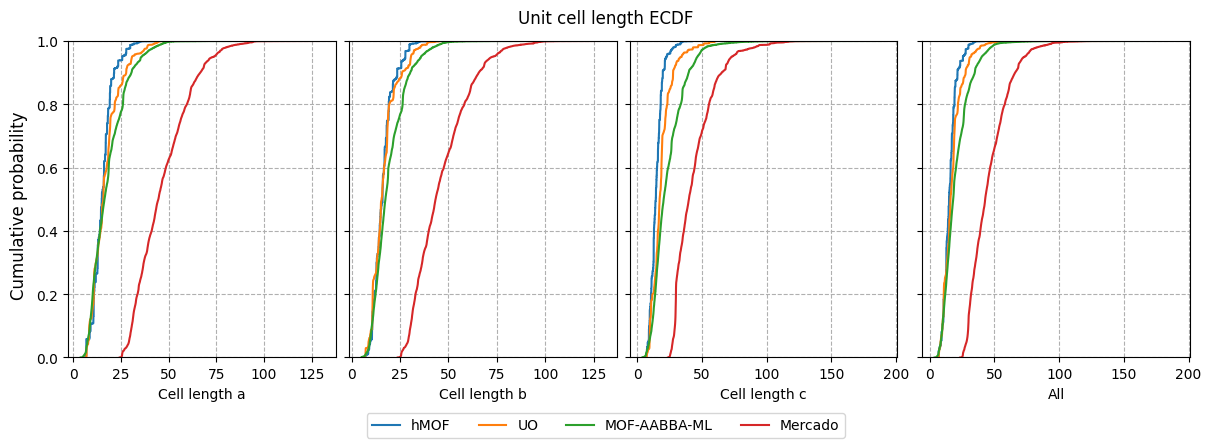

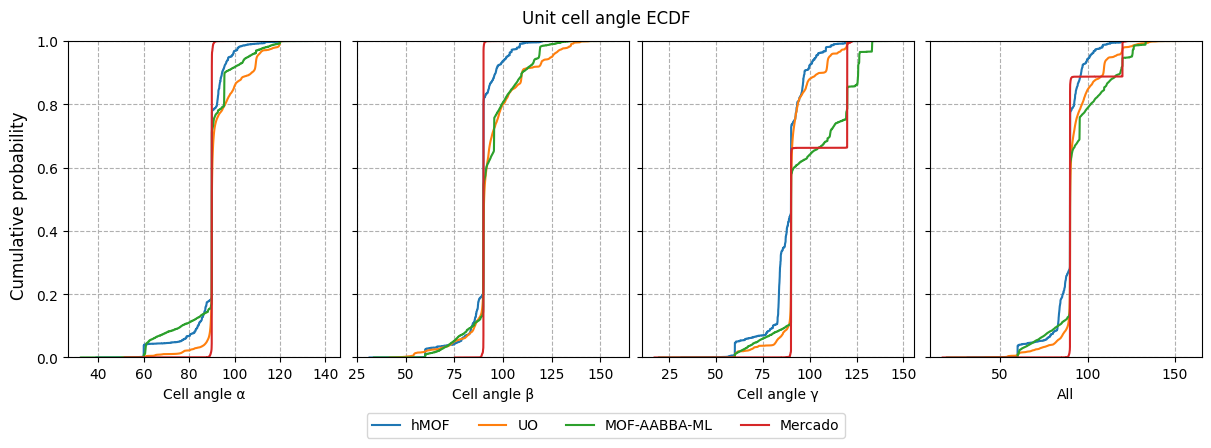

In [17]:
for param in ['length', 'angle']:
    labels = ['a', 'b', 'c'] if param == 'length' else ['α', 'β', 'γ']
    
    fig, axes = plt.subplots(1, 4, figsize=[12, 4], layout='constrained', sharey=True)

    for db in databases:
        with open(f'stats/{db}_unit_cell_stats.json') as fhand:
            data = json.load(fhand)
            
        values = np.array(data[f'cell_{param}s'])

        for i, (ax, lbl) in enumerate(zip(axes, labels)):
            ax.set_axisbelow(True)
            ax.grid(ls='--')
            ax.ecdf(values[:, i])
            ax.set_xlabel(f'Cell {param} {lbl}')
        
        axes[3].set_axisbelow(True)
        axes[3].grid(ls='--')
        axes[3].ecdf(values.ravel(), label=db)
        axes[3].set_xlabel('All')
        #axes[3].legend()
        
    fig.supylabel('Cumulative probability')
    fig.suptitle(f'Unit cell {param} ECDF')
    fig.legend(ncols=4, loc='lower center', bbox_to_anchor=(0.5, -0.1))
    #fig.legend(ncols=4, loc='upper right')
    plt.savefig(f'figures/{param}_ecdf.pdf', bbox_inches='tight')

## Geometric features statistics

In [32]:
df_hmof = pd.read_csv('/home/asarikas/databases/MOFXDB/hMOF/hMOF.csv', index_col='name')
df_uo = pd.read_csv('/home/asarikas/databases/UO/extracted_data/csv/all_MOFs_screening_data.csv', index_col='MOFname')
df_tobacco = pd.read_csv('/home/asarikas/databases/MOFXDB/Tobacco/Tobacco.csv', index_col='name')

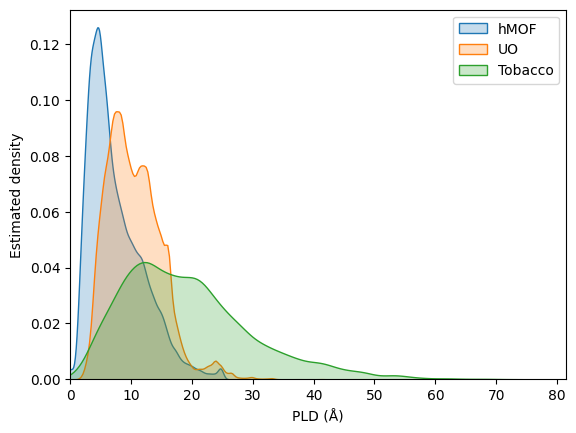

In [69]:
fig, ax = plt.subplots()

sns.kdeplot(df_hmof['pld'], label='hMOF', ax=ax, fill=True)
sns.kdeplot(df_uo['largest_free_sphere_diameter [A]'], label='UO', ax=ax, fill=True)
sns.kdeplot(df_tobacco['pld'], label='Tobacco', ax=ax, fill=True)

ax.set_xlabel('PLD (Å)')
ax.set_ylabel('Estimated density')
ax.set_xlim(0)
ax.legend()

#fig.savefig('figures/pld_kde.pdf', bbox_inches='tight')

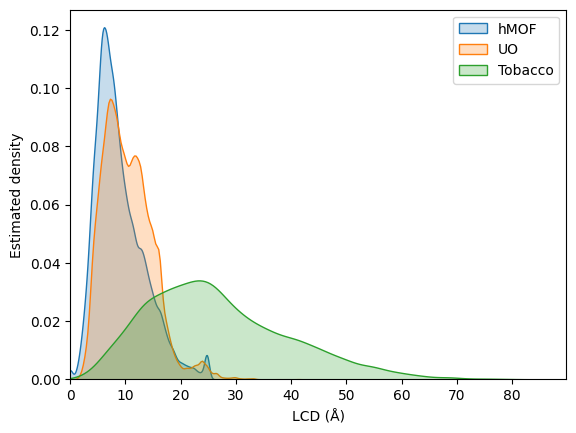

In [63]:
fig, ax = plt.subplots()

sns.kdeplot(df_hmof['lcd'], label='hMOF', ax=ax, fill=True)
sns.kdeplot(df_uo['largest_included_sphere_diameter [A]'], label='UO', ax=ax, fill=True)
sns.kdeplot(df_tobacco['lcd'], label='Tobacco', ax=ax, fill=True)

ax.set_xlabel('LCD (Å)')
ax.set_ylabel('Estimated density')
ax.set_xlim(0)
ax.legend()

#fig.savefig('figures/pld_kde.pdf', bbox_inches='tight')

In [55]:
df_hmof.describe()

KeyError: 'CO2/N2 Selectivity'

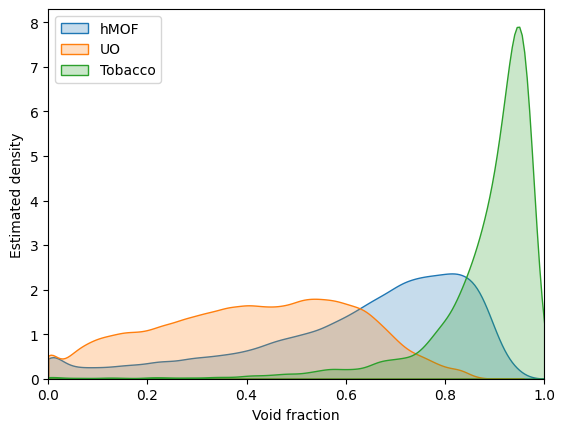

In [50]:
fig, ax = plt.subplots()

sns.kdeplot(df_hmof['void_fraction'], label='hMOF', ax=ax, clip=(0, 1), fill=True)
sns.kdeplot(df_uo['void_fraction'], label='UO', ax=ax, clip=(0, 1), fill=True)
sns.kdeplot(df_tobacco['void_fraction'], label='Tobacco', ax=ax, clip=(0, 1), fill=True)

ax.set_xlabel('Void fraction')
ax.set_ylabel('Estimated density')
ax.set_xlim(0, 1)
ax.legend()

fig.savefig('figures/void_fraction_kde.pdf', bbox_inches='tight')